In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials

from LSMPricing import lsm_pricer
from BinomialTreePricing import btree_pricer
from BSAnalyticalPricing import BSAnalytical
from MonteCarlo import simulate_gbm_paths

In [2]:
currentdir = os.getcwd()
targetdir = currentdir + "\\aapl_eod_2019-ubqxfb"
files = os.listdir(targetdir)

data = pd.read_csv(targetdir + "\\"+files[0], sep=",", low_memory=False)
for i in range(1, len(files)):
    data = pd.concat([data, pd.read_csv(targetdir + "\\"+files[i], sep=",", low_memory=False)])
data.reset_index(inplace=True)

In [3]:
display(data.head())
data.columns

,index,[QUOTE_UNIXTIME],[QUOTE_READTIME],[QUOTE_DATE],[QUOTE_TIME_HOURS],[UNDERLYING_LAST],[EXPIRE_DATE],[EXPIRE_UNIX],[DTE],[C_DELTA],...,[P_LAST],[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[STRIKE_DISTANCE],[STRIKE_DISTANCE_PCT]
0,0,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,0.90886,...,0.01,-0.00034,0.00011,0.00079,-0.00509,-0.00041,1.625550,0.000000,57.9,0.367
1,1,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.00000,...,0.01,-0.00069,0.00010,0.00039,-0.00518,-0.00010,1.461900,200.000000,52.9,0.335
2,2,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.00000,...,0.04,-0.00066,0.00020,0.00000,-0.00425,-0.00009,1.305490,706.000000,47.9,0.303
3,3,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.00000,...,0.01,-0.00120,0.00021,0.00089,-0.00434,-0.00005,1.155130,0.000000,42.9,0.272
4,4,1546462800,2019-01-02 16:00,2019-01-02,16.0,157.92,2019-01-04,1546635600,2.0,1.00000,...,0.01,-0.00109,0.00024,0.00045,-0.00429,-0.00020,1.010620,0.000000,37.9,0.240


Index(['index', '[QUOTE_UNIXTIME]', ' [QUOTE_READTIME]', ' [QUOTE_DATE]',
       ' [QUOTE_TIME_HOURS]', ' [UNDERLYING_LAST]', ' [EXPIRE_DATE]',
       ' [EXPIRE_UNIX]', ' [DTE]', ' [C_DELTA]', ' [C_GAMMA]', ' [C_VEGA]',
       ' [C_THETA]', ' [C_RHO]', ' [C_IV]', ' [C_VOLUME]', ' [C_LAST]',
       ' [C_SIZE]', ' [C_BID]', ' [C_ASK]', ' [STRIKE]', ' [P_BID]',
       ' [P_ASK]', ' [P_SIZE]', ' [P_LAST]', ' [P_DELTA]', ' [P_GAMMA]',
       ' [P_VEGA]', ' [P_THETA]', ' [P_RHO]', ' [P_IV]', ' [P_VOLUME]',
       ' [STRIKE_DISTANCE]', ' [STRIKE_DISTANCE_PCT]'],
      dtype='object')

In [5]:
first_day_options = data[data[" [QUOTE_DATE]"] == " 2019-01-02"]
first_day_3m_options = first_day_options[first_day_options[" [EXPIRE_DATE]"] == ' 2019-03-15']
# first_day_3m_options[first_day_options[" [STRIKE]"] == 130][" [P_IV]"]

Text(0.5, 1.0, 'AAPL 3M 2019 IV')

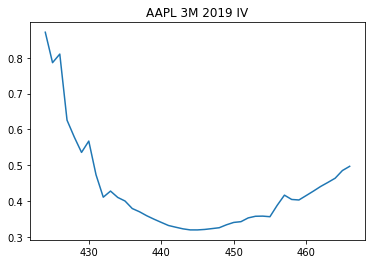

In [87]:
plt.plot(first_day_3m_options[[" [STRIKE_DISTANCE]", " [STRIKE]", " [C_ASK]", " [P_ASK]", " [P_IV]", " [C_IV]"]][" [C_IV]"].astype(float))
plt.title("AAPL 3M 2019 IV")

In [6]:
start_date="2018-01-01"
end_date="2019-01-01"
time_interval="daily"

aapl = YahooFinancials("AAPL")
aapl = aapl.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
aapl = pd.DataFrame(aapl["AAPL"]['prices'])
aapl = aapl.drop('date', axis=1).set_index('formatted_date')
aapl.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2018-01-02,43.075001,42.314999,42.540001,43.064999,102223600,40.950493
2018-01-03,43.637501,42.990002,43.132500,43.057499,118071600,40.943359
2018-01-04,43.367500,43.020000,43.134998,43.257500,89738400,41.133545
2018-01-05,43.842499,43.262501,43.360001,43.750000,94640000,41.601856
2018-01-08,43.902500,43.482498,43.587502,43.587502,82271200,41.447350


In [8]:
sig = np.std(aapl["adjclose"].pct_change()[1:])*np.sqrt(len(aapl))
nsims = 10000
S0 = 157.92
T = .25
discrete_freq = 252
OP_TYPE = "put"
K = 155.0
r = .016
POLY_DEGREE = 5

In [46]:
actual = []
for i in range(130, 180, 5):
    actual_data_op = first_day_3m_options[first_day_3m_options[" [STRIKE]"] == i]
    actual_call = (float(actual_data_op[' [C_BID]']) + float(actual_data_op[' [C_ASK]']))/2
    actual_put = (float(actual_data_op[' [P_BID]']) + float(actual_data_op[' [P_ASK]']))/2
    actual.append((actual_put, actual_call))
    # print("Actual American Put (", str(i), "):", actual_put)
    # print("Actual American call (", str(i), "):", actual_call)
actual = np.array(actual)

In [33]:
lsm = []
for i in range(130, 180, 5):
    put_price = lsm_pricer("ap", nsims, S0, i, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = lsm_pricer("ac", nsims, S0, i, r, sig, T, discrete_freq, POLY_DEGREE)
    lsm.append((put_price, call_price))
    # print("LSM MC American Put ",str(i),"): ", put_price)
    # print("LSM MC American call ",str(i), "):", call_price)
lsm = np.array(lsm)

bt = []
for i in range(130, 180, 5):
    # Without control variates
    put_price = btree_pricer(S0, i, sig, r, T, 1000, "ap")
    call_price = btree_pricer(S0, i, sig, r, T, 1000, "ac")
    bt.append((put_price, call_price))
    # print("BT American Put (",str(i),"):", put_price)
    # print("BT American call (",str(i), "):", call_price)
bt = np.array(bt)

In [39]:
(lsm - bt)/lsm

array([[-0.17320812, -0.00914772],
       [-0.07821861, -0.00333914],
       [-0.06369654,  0.00194984],
       [-0.04994496, -0.0307554 ],
       [-0.01716256, -0.01663296],
       [-0.02786072, -0.03120568],
       [ 0.02405635, -0.0297449 ],
       [-0.00332162, -0.00855574],
       [-0.00631841,  0.00210737],
       [-0.00943647, -0.03589975]])

In [41]:
fnsims = []
for i in range(1000, 100000, 4000):
    # put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = lsm_pricer("ac", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    fnsims.append((put_price, call_price))
fnsims = np.array(fnsims)

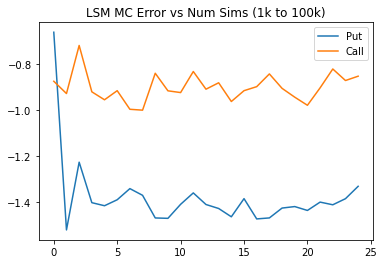

In [75]:
# put and call error vs num sims
plt.plot(fnsims - actual[5])
plt.legend(["Put", "Call"])
plt.title("LSM MC Error vs Num Sims (1k to 100k)")
plt.show()

In [85]:
fntree = []
for i in range(12, 4000, 10):
    # put_price = lsm_pricer("ap", i, S0, K, r, sig, T, discrete_freq, POLY_DEGREE)
    call_price = btree_pricer(S0, K, sig, r, T, i, "ac")
    put_price = btree_pricer(S0, K, sig, r, T, i, "ap")
    fntree.append((put_price, call_price))
fntree = np.array(fntree)

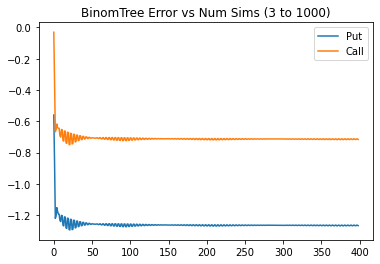

In [86]:
# put and call error vs num sims
plt.plot(fntree - actual[5])
plt.legend(["Put", "Call"])
plt.title("BinomTree Error vs Num Sims (3 to 1000)")
plt.show()

In [81]:
actual
lsm
bt

array([[ 0.77282895, 29.20956758],
       [ 1.37002017, 24.82470547],
       [ 2.26330519, 20.7345504 ],
       [ 3.51663075, 17.00241566],
       [ 5.17801396, 13.67553085],
       [ 7.27718713, 10.78328464],
       [ 9.84346874,  8.35443237],
       [12.83431003,  6.34436356],
       [16.21116279,  4.71341613],
       [19.96306498,  3.45330862]])

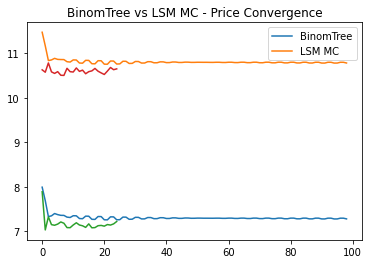

In [84]:
plt.plot(fntree)
plt.plot(fnsims)
plt.title("BinomTree vs LSM MC - Price Convergence")
plt.legend(["BinomTree", "LSM MC"])
plt.show()